<a href="https://colab.research.google.com/github/DanielMaschmann/PHANGS_HST_star_cluster/blob/main/accessing_phangs_hst_cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
# packages needed to for file management,
# downloading and unpacking compressed catalogs.
import os
from urllib3 import PoolManager
import tarfile

# basic packages for data handling and plotting
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

from astropy.io import fits
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats

from scipy.constants import c as speed_of_light

# we download a file with multiple helpfull methods from the same git repository.
# These functions are well documented to facilitate further reading.
helper_func_url = 'https://raw.githubusercontent.com/DanielMaschmann/PHANGS_HST_star_cluster/main/helper_func.py'
# Download file. This will save them in the working directory.
http = PoolManager()
http_request_object = http.request('GET', helper_func_url, preload_content=False)
with open('helper_func.py', 'wb') as out:
    while True:
        data = http_request_object.read()
        if not data:
            break
        out.write(data)

!pip install dust_extinction

import helper_func






In this Jupyter Notebook we will demonstrate to access and handle the cluster catalog for the Galaxy NGC 1566

In [62]:
# we use NGC 1566 as an example
galaxy_name = 'ngc1365'


Download the cluster and compact associataion catalogs and extract them.
The catalog data release is described here https://archive.stsci.edu/hlsp/phangs/phangs-cat and the list of the data products can be found here: https://archive.stsci.edu/hlsp/phangs.html#hst_image_products_table \

In [40]:
# get the file name and the URL for the catalogs
url_path_structure = 'https://archive.stsci.edu/hlsps/phangs-cat/dr4/bundles/'
catalog_file_name_compressed = ('hlsp_phangs-cat_hst_acs-uvis_%s_multi_v1_cats.tar.gz' %
                    galaxy_name)
url = url_path_structure + catalog_file_name_compressed
# Download compressed catalogs. This will save them in the working directory.
http = PoolManager()
http_request_object = http.request('GET', url, preload_content=False)
with open(catalog_file_name_compressed, 'wb') as out:
    while True:
        data = http_request_object.read()
        if not data:
            break
        out.write(data)
# get the present work directory (pwd) where we will extract the file
pwd = os.getcwd()
src_path = pwd + '/' + catalog_file_name_compressed
# extract the compressed files locally
tar = tarfile.open(src_path, 'r:gz')
tar.extractall(pwd)
tar.close()

Now we do the exact same thing to download the HST data

In [41]:
# download HST images
img_file_name_compressed = 'hlsp_phangs-hst_hst_wfc3-uvis_%s_multi_v1_drc-bundle.tar.gz' % galaxy_name
url = 'https://archive.stsci.edu/hlsps/phangs-hst/' + galaxy_name + '/' + img_file_name_compressed
# Download compressed catalogs. This will save them in the working directory.
http = PoolManager()
http_request_object = http.request('GET', url, preload_content=False)
with open(img_file_name_compressed, 'wb') as out:
    while True:
        data = http_request_object.read()
        if not data:
            break
        out.write(data)
# get the present work directory (pwd) where we will extract the file
pwd = os.getcwd()
src_path = pwd + '/' + img_file_name_compressed
# extract the compressed files locally
tar = tarfile.open(src_path, 'r:gz')
tar.extractall(pwd)
tar.close()

Now we will access the cluster catalog for human class 1 and 2 and the catalog for compact associations (class 3)


In [63]:
# open cluster and association catalogs
cat_hum_cl12_table = Table.read('catalogs/hlsp_phangs-cat_hst_uvis_%s_multi_v1_obs-human-cluster-class12.fits' % galaxy_name)
cat_hum_cl3_table = Table.read('catalogs/hlsp_phangs-cat_hst_uvis_%s_multi_v1_obs-human-compact-association-class3.fits' % galaxy_name)
# inspect the content
cat_hum_cl12_table


INDEX,ID_PHANGS_CLUSTER,ID_PHANGS_CANDIDATE,ID_PHANGS_ALLSOURCES,PHANGS_X,PHANGS_Y,PHANGS_RA,PHANGS_DEC,PHANGS_CLUSTER_CLASS_HUMAN,PHANGS_CLUSTER_CLASS_ML_VGG,PHANGS_CLUSTER_CLASS_ML_VGG_QUAL,PHANGS_F275W_VEGA,PHANGS_F275W_VEGA_ERR,PHANGS_F336W_VEGA,PHANGS_F336W_VEGA_ERR,PHANGS_F438W_VEGA,PHANGS_F438W_VEGA_ERR,PHANGS_F555W_VEGA,PHANGS_F555W_VEGA_ERR,PHANGS_F814W_VEGA,PHANGS_F814W_VEGA_ERR,PHANGS_F275W_mJy,PHANGS_F275W_mJy_ERR,PHANGS_F336W_mJy,PHANGS_F336W_mJy_ERR,PHANGS_F438W_mJy,PHANGS_F438W_mJy_ERR,PHANGS_F555W_mJy,PHANGS_F555W_mJy_TOT_ERR,PHANGS_F814W_mJy,PHANGS_F814W_mJy_TOT_ERR,PHANGS_NON_DETECTION_FLAG,PHANGS_NO_COVERAGE_FLAG,PHANGS_CI,CC_CLASS
,,,,,,deg,deg,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,,,,
int64,int64,int64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7
1,3,7,290,2763.55,1269.04,53.417942161299116,-36.16967457368882,1.0,2,0.7,19.464304676535193,0.02540987671452717,19.73208511079264,0.024410303192057514,20.947648880166156,0.020036740386999225,20.710539930685954,0.020670956113805157,19.894425414242743,0.019229517586154255,0.01451971625308685,0.0003401497453430661,0.01566051196529833,0.00035244275890049823,0.01721632482182568,0.00031803651210798775,0.019015337048604895,0.0003623882064080733,0.026636050787713455,0.00047222359847339456,0.0,0.0,1.5126229957095525,outside
2,5,9,674,2758.3,1271.16,53.41801373075695,-36.16965123430131,2.0,4,0.9,19.63693861247976,0.047939635776827486,19.92290839991521,0.05030684387819751,21.219589825904634,0.0509736475244119,20.973406982200675,0.04854907050906408,20.115448779842218,0.03910104363731583,0.01238524365851611,0.000547404984958698,0.013136408345397003,0.0006092747421430134,0.013401828918615705,0.0006298240554593405,0.01492647325450671,0.0006681094114414243,0.021730038113956244,0.0007833544234204509,0.0,0.0,1.8778943283279708,outside
3,6,12,307,2755.96,1275.43,53.41804562427054,-36.16960423718248,2.0,2,0.7,19.468017384374004,0.03021804515979378,19.625143563720634,0.02931638145170138,20.819991326567322,0.024543518578253647,20.59132150566902,0.0261229853645745,19.952227589696864,0.028154365255383576,0.014470150437763181,0.00040313348691944993,0.017281545316574116,0.00046709197009031487,0.019364374331669765,0.000438177179861851,0.021222248606149494,0.0005111209327786031,0.02525509253553077,0.0006555475030603973,0.0,0.0,1.6317538411753678,ycl
4,9,16,5659,2766.11,1289.36,53.41790722451964,-36.169450944551734,2.0,3,0.4,24.038012761224692,0.5618851021726047,23.522512491156363,0.28830127949053935,24.3587230238797,0.13961699308907702,23.510007500704223,0.09329889718728733,22.54077866666983,0.07252473720211322,0.00021501803840887396,0.00011138632508794066,0.0004771281097448456,0.0001268209599551322,0.0007438935454011868,9.57543546735229e-05,0.001443168362928687,0.00012413749371182096,0.0023277081829476093,0.00015564105285077726,0.0,0.0,1.5345526178537647,outside
5,14,26,16589,2485.84,1392.17,53.421727897107424,-36.16831899866826,2.0,2,0.9,23.794810328416357,0.2586466628338135,23.54123453133158,0.1623672196464858,24.138365391612044,0.08428813915882667,23.98028494130853,0.0680574987697296,23.577719467320104,0.10548030915230364,0.0002690022227907117,6.414638858860322e-05,0.00046897121555057977,7.020273052374653e-05,0.0009112842060594688,7.081573583161049e-05,0.000935849523321562,5.872073329172839e-05,0.000895678631170727,8.710299131528906e-05,0.0,0.0,1.774993130372367,outside
6,18,30,3818,2648.97,1406.63,53.41950395444636,-36.16816014377453,2.0,4,0.8,23.606494883078952,0.2204063451407569,23.33555984641979,0.13974634579710665,23.50486054106676,0.051130127707282355,23.03735874148946,0.03167630234552527,21.99919657327484,0.03223469527141864,0.00031994995009756083,6.50153047553346e-05,0.0005667820157481697,7.302406159169883e-05,0.0016332617210497496,

In [64]:
# get all data we need for the following examples
# coordinates
ra_hum_cl12, dec_hum_cl12 = cat_hum_cl12_table['PHANGS_RA'], cat_hum_cl12_table['PHANGS_DEC']
ra_hum_cl3, dec_hum_cl3 = cat_hum_cl3_table['PHANGS_RA'], cat_hum_cl3_table['PHANGS_DEC']
# morphological classification
class_human_hum_cl12 = cat_hum_cl12_table['PHANGS_CLUSTER_CLASS_HUMAN']
class_human_hum_cl3 = cat_hum_cl3_table['PHANGS_CLUSTER_CLASS_HUMAN']
# v-band flux
phangs_id_hum_cl12 = cat_hum_cl12_table['ID_PHANGS_CLUSTER']
phangs_id_hum_cl3 = cat_hum_cl3_table['ID_PHANGS_CLUSTER']
# v-band flux
v_band_flux_hum_cl12 = cat_hum_cl12_table['PHANGS_F555W_mJy']
v_band_flux_hum_cl3 = cat_hum_cl3_table['PHANGS_F555W_mJy']
# v-band mag
v_band_mag_hum_cl12 = cat_hum_cl12_table['PHANGS_F555W_VEGA']
v_band_mag_hum_cl3 = cat_hum_cl3_table['PHANGS_F555W_VEGA']
# color
color_u_b_hum_cl12 = cat_hum_cl12_table['PHANGS_F336W_VEGA'] - cat_hum_cl12_table['PHANGS_F438W_VEGA']
color_v_i_hum_cl12 = cat_hum_cl12_table['PHANGS_F555W_VEGA'] - cat_hum_cl12_table['PHANGS_F814W_VEGA']
color_u_b_hum_cl3 = cat_hum_cl3_table['PHANGS_F336W_VEGA'] - cat_hum_cl3_table['PHANGS_F438W_VEGA']
color_v_i_hum_cl3 = cat_hum_cl3_table['PHANGS_F555W_VEGA'] - cat_hum_cl3_table['PHANGS_F814W_VEGA']


In order to visualize the location of the clusters we have to access the image data. As an example we use here the V-band (F555W).

In [65]:
# load
v_band_img_hdu = fits.open('%s/hlsp_phangs-hst_hst_wfc3-uvis_%s_f555w_v1_exp-drc-sci.fits' % (galaxy_name, galaxy_name))
v_band_img_header = v_band_img_hdu[0].header
v_band_img_data = v_band_img_hdu[0].data
v_band_img_wcs = WCS(v_band_img_header)

# change the image data from electron counts to units of Jy
# wavelength in angstrom
pivot_wavelength = v_band_img_header['PHOTPLAM']
# inverse sensitivity, ergs/cm2/Ang/electron
sensitivity = v_band_img_header['PHOTFLAM']
# speed of light in Angstrom/s
c = speed_of_light * 1e10
# change the conversion facto to get erg s−1 cm−2 Hz−1
f_nu = sensitivity * pivot_wavelength ** 2 / c
# change to get Jy
conversion_factor = f_nu * 1e23

v_band_img_data *= conversion_factor


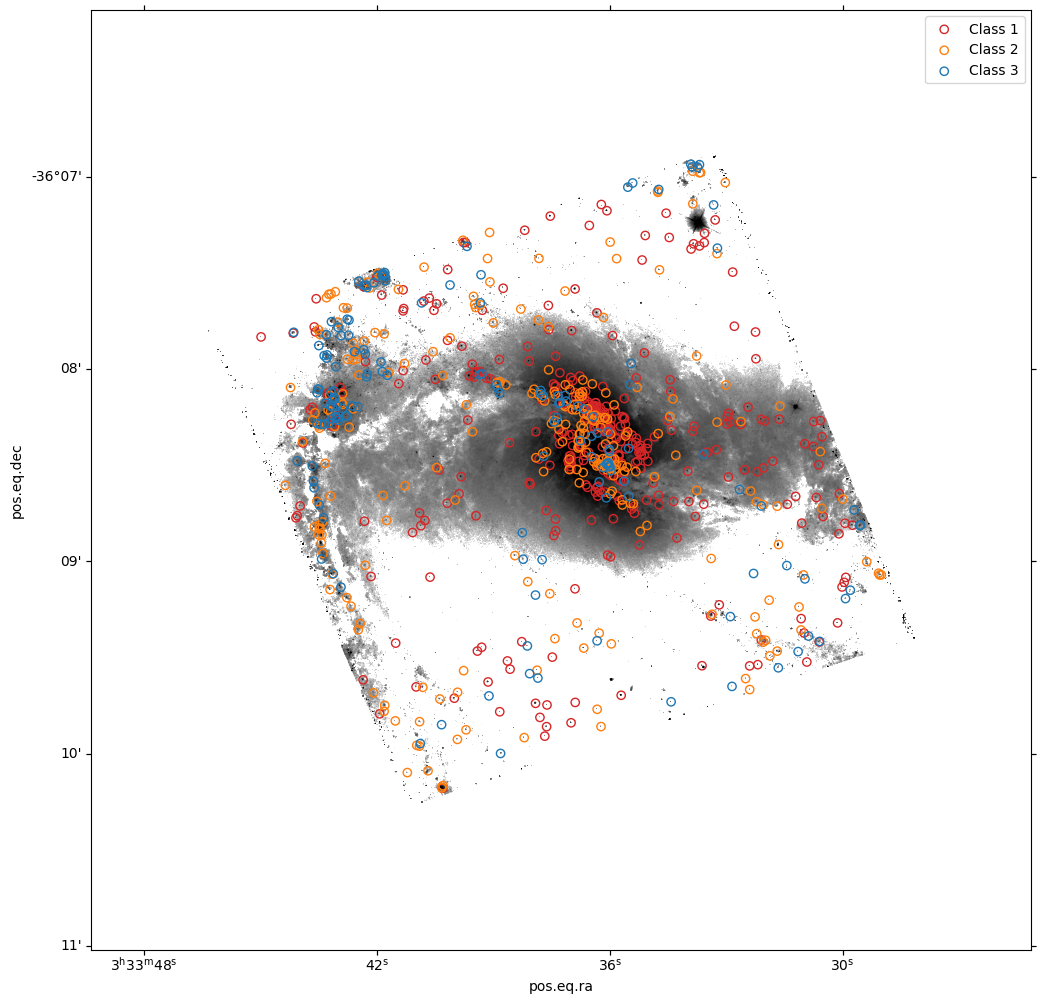

In [45]:

mean, median, std = sigma_clipped_stats(v_band_img_data, sigma=3.0)
norm = LogNorm(0.1*std, median + 50*std)
figure = plt.figure(figsize=(10, 10))
ax_img = figure.add_axes([0.05, 0.05 , 0.94, 0.94], projection=v_band_img_wcs)
ax_img.imshow(v_band_img_data, cmap='Greys', norm=norm)

coords_hum_cl12 = SkyCoord(ra=ra_hum_cl12, dec=dec_hum_cl12)
coords_hum_cl12_pix = v_band_img_wcs.world_to_pixel(coords_hum_cl12)

coords_hum_cl3 = SkyCoord(ra=ra_hum_cl3, dec=dec_hum_cl3)
coords_hum_cl3_pix = v_band_img_wcs.world_to_pixel(coords_hum_cl3)

ax_img.scatter(coords_hum_cl12_pix[0][class_human_hum_cl12==1], coords_hum_cl12_pix[1][class_human_hum_cl12==1], facecolor='None', edgecolor='tab:red', linewidth=1, label='Class 1')
ax_img.scatter(coords_hum_cl12_pix[0][class_human_hum_cl12==2], coords_hum_cl12_pix[1][class_human_hum_cl12==2], facecolor='None', edgecolor='tab:orange', linewidth=1, label='Class 2')
ax_img.scatter(coords_hum_cl3_pix[0], coords_hum_cl3_pix[1], facecolor='None', edgecolor='tab:blue', linewidth=1, label='Class 3')

ax_img.legend()


In [66]:
# cutout of the brightest class 1 , 2 and 3 cluster
mask_class1 = class_human_hum_cl12 == 1
mask_class2 = class_human_hum_cl12 == 2
mask_brigh_cluster_class1 = v_band_mag_hum_cl12[mask_class1] == np.min(v_band_mag_hum_cl12[mask_class1])
mask_brigh_cluster_class2 = v_band_mag_hum_cl12[mask_class2] == np.min(v_band_mag_hum_cl12[mask_class2])
mask_brigh_cluster_class3 = v_band_mag_hum_cl3 == np.min(v_band_mag_hum_cl3)

coord_bright_class1 = coords_hum_cl12[mask_class1][mask_brigh_cluster_class1]
coord_bright_class2 = coords_hum_cl12[mask_class2][mask_brigh_cluster_class2]
coord_bright_class3 = coords_hum_cl3[mask_brigh_cluster_class3]

cutout_bright_class1 = helper_func.get_img_cutout(img=v_band_img_data,
                                                  wcs=v_band_img_wcs,
                                                  coord=coord_bright_class1,
                                                  cutout_size=(2, 2))
cutout_bright_class2 = helper_func.get_img_cutout(img=v_band_img_data,
                                                  wcs=v_band_img_wcs,
                                                  coord=coord_bright_class2,
                                                  cutout_size=(2, 2))
cutout_bright_class3 = helper_func.get_img_cutout(img=v_band_img_data,
                                                  wcs=v_band_img_wcs,
                                                  coord=coord_bright_class3,
                                                  cutout_size=(2, 2))



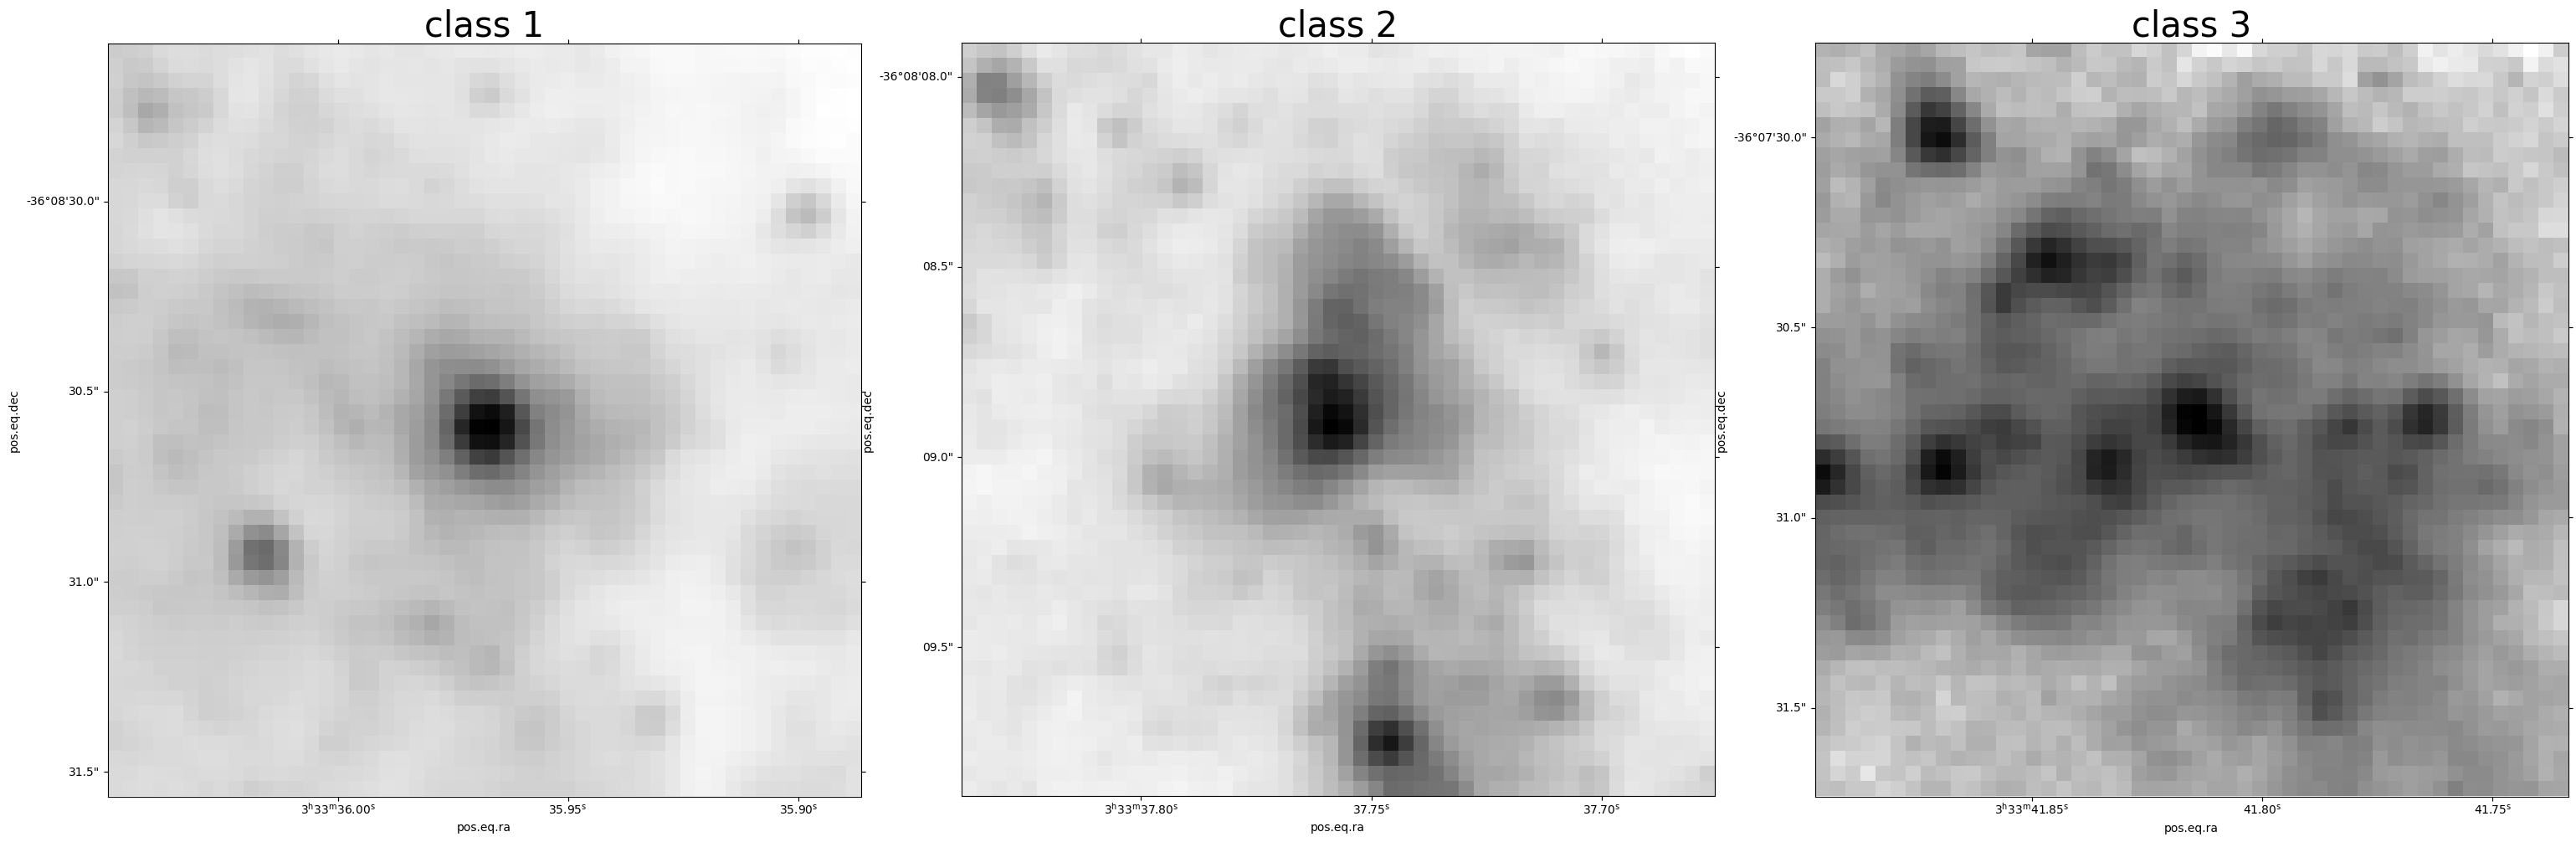

In [67]:
figure_cutouts = plt.figure(figsize=(30, 10))
ax_cutout_class1 = figure_cutouts.add_axes([0.01, 0.05 , 0.3, 0.94], projection=cutout_bright_class1.wcs)
ax_cutout_class2 = figure_cutouts.add_axes([0.35, 0.05 , 0.3, 0.94], projection=cutout_bright_class2.wcs)
ax_cutout_class3 = figure_cutouts.add_axes([0.69, 0.05 , 0.3, 0.94], projection=cutout_bright_class3.wcs)

ax_cutout_class1.imshow(cutout_bright_class1.data, norm=LogNorm(), cmap='Greys')
ax_cutout_class2.imshow(cutout_bright_class2.data, norm=LogNorm(), cmap='Greys')
ax_cutout_class3.imshow(cutout_bright_class3.data, norm=LogNorm(), cmap='Greys')

ax_cutout_class1.set_title('class 1', fontsize=30)
ax_cutout_class2.set_title('class 2', fontsize=30)
ax_cutout_class3.set_title('class 3', fontsize=30)

plt.show()


NameError: name 'dust_tools' is not defined

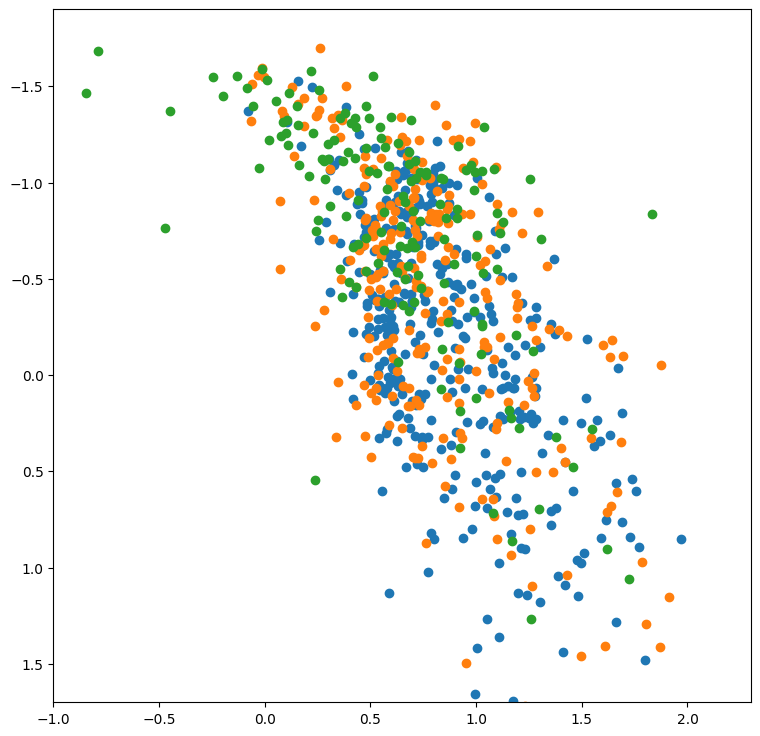

In [68]:
# color-color distribution of different clusters

vi_int = 1.2
ub_int = -1.9
av_value = 1

x_lim_vi = (-1.0, 2.3)
y_lim_ub = (1.7, -1.9)

fig, ax = plt.subplots(1, 1, figsize=(9, 9))

ax.scatter(color_v_i_hum_cl12[mask_class1], color_u_b_hum_cl12[mask_class1])

ax.scatter(color_v_i_hum_cl12[mask_class2], color_u_b_hum_cl12[mask_class2])
ax.scatter(color_v_i_hum_cl3, color_u_b_hum_cl3)

ax.set_ylim(y_lim_ub)
ax.set_xlim(x_lim_vi)

helper_func.plot_reddening_vect(ax=ax,
                        init_x_color=1.2, init_y_color=-1.4, av_value_mag=1,
                        arrow_line_width=2, arrow_line_color='k',
                        show_av_value=True, text_font_size=20, text_color='k', x_text_offset=0.1, y_text_offset=-0.3)



plt.show()





In [19]:
alma_url = 'https://www.canfar.net/storage/vault/file/phangs/RELEASES/PHANGS-ALMA/by_product/broad_mom0/ngc1566_12m+7m+tp_co21_15as_broad_mom0.fits'

alma_hdu = fits.open(alma_url)
alma_hdu.info()

Filename: /root/.astropy/cache/download/url/ad71780fc028f1ccf05dc70b72135c9a/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      70   (576, 838)   float32   
